In this Notebook we will see:
* A good Initialization will help you to train your network.
* Regularization will help you reduce overfitting.
* Regularization will drive your weights to lower values.
* L2 regularization and Dropout are two very effective regularization techniques.

## Regularization

Regularization is a technique that helps machine learning models generalize better by making modifications in the learning algorithm. This helps prevent overfitting and allows our model to work better on data that it hasn't seen during training. In this Notebook, we will learn about the different regularize

### Import Libraries:
first we will import all the packages that are required for this exercise. 
- [numpy](www.numpy.org) is the main package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- np.random.seed(1) is used to keep all the random function calls consistent.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
np.random.seed(1)

To get started, run the following cell to load the packages and the planar dataset you will try to classify.

Train Dataset


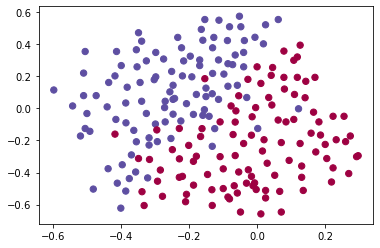

Test Dataset


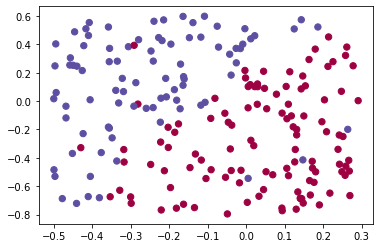

In [2]:
from utils import load_2D_dataset
train_X, train_Y, test_X, test_Y = load_2D_dataset()

## Implementation 
In this notebook, we will train a Neural Network with two hidden layers and ReLU as an activation function.

**Here is our neural network**:
<img src="imgs/NN_e3_fixed.png" style="width:800px;height:300px;">

Because we implemented a lot of the required functions to train a neural network and many activation functions and them derivatives in the second exercise, we will not implement them again in this exercise. Still, we will import them from `utils.py`.


In [3]:
from utils import backward_propagation  # an Implementation for the backpropagation for the network in this exercise
from utils import update_parameters     # Optimize the parameters of the network using the gradient
from utils import predict_dec           # make an inference
from utils import sigmoid, relu         # activation functions

In [4]:
def forward_propagation(X, parameters):
    # Retrieve each parameter from the dictionary "parameters"
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]

    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)
    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)
    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    # Test if the shape correct is
    assert(a3.shape == (1, X.shape[1]))
    
    cache = (z1, a1, W1, b1, z2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache

## Initialize the model's parameters:
We will begin to use random weights that we will optimize using backward propagation.

In [5]:
def initialize_parameters(layer_dims, init_method ="xavier"):
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    if init_method == "xavier":
        for l in range(1, L):
            parameters['W'+str(l)] = np.random.randn(layer_dims[l], layer_dims[l - 1]) / np.sqrt(layer_dims[l - 1])
            parameters['b'+str(l)] = np.zeros((layer_dims[l], 1))
            
    elif init_method == "zeros":
        for l in range(1, L):
            parameters['W' + str(l)] = np.zeros((layer_dims[l], layer_dims[l-1]))
            parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
        
    return parameters

##  L2 Regularization
<img src="imgs/overfit.jpg" style="width:450px;height:250px;">

The standard way to avoid overfitting is called L2 regularization. It consists of appropriately modifying your cost function, from: $$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} \tag{1}$$ To: $$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost} \tag{2}$$

Here, λ is the regularization parameter.

<img src="imgs/rg.png" style="width:450px;height:250px;">


### Implementation of Loss function: 
we will implement the loss function with equation 1, this function takes the output of forward_propagation and the true label as input and returns the loss. 

In [6]:
def compute_cost(a3, Y):
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    loss = 1./m * np.nansum(logprobs)
    return loss

In [7]:
def compute_cost_with_regularization(a3, Y, parameters, lambd):
    m = Y.shape[1]
    # Only punish large weights, not biases!
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
     
    cross_entropy_cost = compute_cost(a3, Y) # This gives you the cross-entropy part of the cost
    
    #### L1 regularization ####
    #    L1_regularization_cost = lambda * (np.sum(np.abs(W1)) + np.sum(np.abs(W2)) + np.sum(np.abs(W3))) / (2 * m)
    ###                    ####
    L2_regularization_cost = lambd * (np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3))) / (2 * m)
    
    cost = cross_entropy_cost + L2_regularization_cost
    
    return cost

### Optimization
we want to train our model. We will combine all functions from the forward propagation calculation , then estimate the loss function `compute_cost_with_regularization` and the gradient `backward_propagation_with_regularization`,  update the parameters `update_parameters` to reduce the loss and lastley estimate the accuracy of the model using `predict` function.

In [8]:
from utils import backward_propagation_with_regularization  # an Implementation for the backpropagation for the network with regularization

In [9]:
# GRADED FUNCTION: optimize
def optimize(X, Y, X_test, Y_test, learning_rate = 0.01, num_iterations = 15000, print_cost = True,  lambd = 0, init_method ="xavier"):
    
    grads      = {}
    costs      = {'train': [], 'test':[]} # to keep track of the loss
    accuracies = {'train': [], 'test':[]} # to keep track of the accuracy
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 60,35, 1]
    

    parameters = initialize_parameters(layers_dims,init_method)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
        
        # Cost function
        if lambd == 0:
            cost = compute_cost(a3, Y)
        else:
            cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        # Back Propagation
        if lambd == 0:
            grads = backward_propagation(X, Y, cache)
        elif lambd != 0:
            grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost Train after iteration {}: {:.3f}".format(i, cost))
            # Compute the predictions 
            predictions_train = predict_dec(X,parameters)
            predictions_test  = predict_dec(X_test,parameters)
            # Compute the accuracy 
            accuracy_train = np.mean(predictions_train[0,:] == Y[0,:])
            accuracy_test  = np.mean(predictions_test[0,:]  == Y_test[0,:])
            # Cost function
            a3_a, _ = forward_propagation(X_test, parameters)
            if lambd == 0:
                cost_test = compute_cost(a3_a, Y_test)
            else:
                cost_test = compute_cost_with_regularization(a3_a, Y_test, parameters, lambd)
            print("Cost Test after iteration {}: {:.3f}".format(i, cost_test))
            print("================")

            costs['train'].append(cost)
            costs['test'].append(cost_test)
            accuracies['train'].append(accuracy_train)            
            accuracies['test'].append(accuracy_test)

            
    # plot the loss, accuracy
    fig1, ax1 = plt.subplots(figsize=(10,12), nrows=1, ncols=1)
    ax1.plot(costs['train'],label='train_loss')
    ax1.plot(costs['test'] ,label='test_loss')
    ax1.set_ylabel('cost')
    ax1.set_xlabel('iterations (per hundreds)')
    ax1.set_title("Learning rate =" + str(learning_rate))
    ax1.legend(loc='best')
    ax1.set_ylim([0,1])
    plt.show()
    return parameters

First, we will train the network without regularization and with zero initialization 

Cost Train after iteration 0: 0.693
Cost Test after iteration 0: 0.693
Cost Train after iteration 1000: 0.693
Cost Test after iteration 1000: 0.694
Cost Train after iteration 2000: 0.693
Cost Test after iteration 2000: 0.694
Cost Train after iteration 3000: 0.693
Cost Test after iteration 3000: 0.694


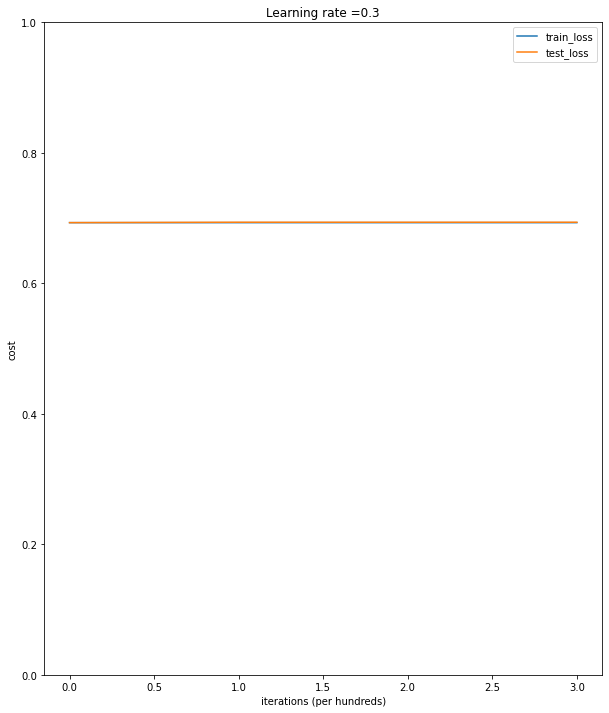

In [10]:
# No regularization, initialization with zeros
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.3, 
                      num_iterations = 3001, 
                      lambd = 0,
                      init_method= "zeros", #->initialization with zeros
                      print_cost = True
                      )

As we see, there is no improvement in accuracy or reduction in loss.

Cost Train after iteration 0: 0.721
Cost Test after iteration 0: 0.698
Cost Train after iteration 1000: 0.188
Cost Test after iteration 1000: 0.267
Cost Train after iteration 2000: 0.186
Cost Test after iteration 2000: 0.292
Cost Train after iteration 3000: 0.148
Cost Test after iteration 3000: 0.321
Cost Train after iteration 4000: 0.136
Cost Test after iteration 4000: 0.378
Cost Train after iteration 5000: 0.139
Cost Test after iteration 5000: 0.454
Cost Train after iteration 6000: 0.109
Cost Test after iteration 6000: 0.563
Cost Train after iteration 7000: 0.098
Cost Test after iteration 7000: 0.682


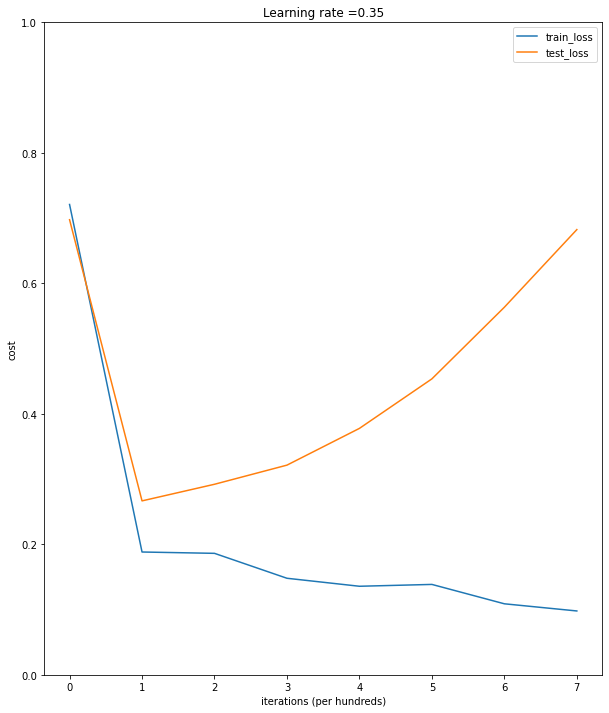

In [11]:
#Initialization with xavier, no regularization
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.35, 
                      num_iterations = 7001, 
                      lambd = 0, # -> no regularization (0 * regularization_loss)
                      init_method= "xavier",
                      print_cost = True
                      )

The train accuracy is 94.8%, while the test accuracy is 92.4%. This is the baseline model. We will observe the effects of regularization on this model. Let's record the results.s

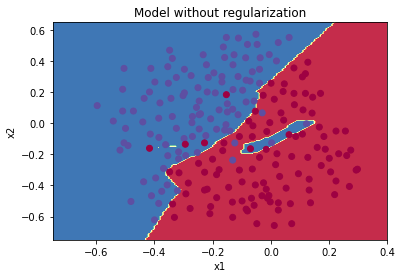

In [12]:
from utils import plot_decision_boundary
plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(x.T,parameters), train_X, train_Y.ravel())

Cost Train after iteration 0: 0.780
Cost Test after iteration 0: 0.766
Cost Train after iteration 1000: 0.271
Cost Test after iteration 1000: 0.308
Cost Train after iteration 2000: 0.259
Cost Test after iteration 2000: 0.295
Cost Train after iteration 3000: 0.255
Cost Test after iteration 3000: 0.292
Cost Train after iteration 4000: 0.253
Cost Test after iteration 4000: 0.293
Cost Train after iteration 5000: 0.250
Cost Test after iteration 5000: 0.292
Cost Train after iteration 6000: 0.251
Cost Test after iteration 6000: 0.295
Cost Train after iteration 7000: 0.249
Cost Test after iteration 7000: 0.294


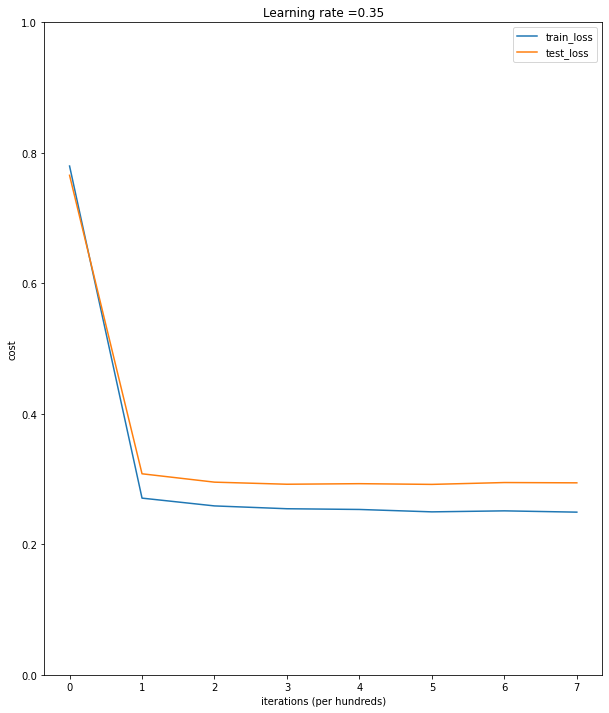

In [13]:
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.35, 
                      num_iterations = 7001, 
                      lambd = 0.5, 
                      init_method= "xavier",
                      print_cost = True
                      )

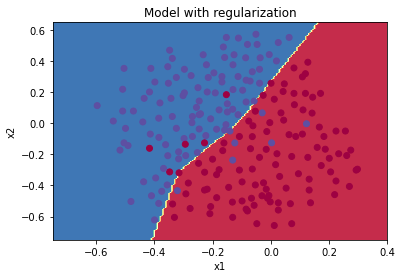

In [14]:
plt.title("Model with regularization")
axes = plt.gca()
axes.set_xlim([-0.75, 0.40])
axes.set_ylim([-0.75, 0.65])
plot_decision_boundary(lambda x: predict_dec(x.T,parameters), train_X, train_Y.ravel())

Cost Train after iteration 0: 7.649
Cost Test after iteration 0: 7.299
Cost Train after iteration 1000: 0.693
Cost Test after iteration 1000: 0.694
Cost Train after iteration 2000: 0.693
Cost Test after iteration 2000: 0.694
Cost Train after iteration 3000: 0.693
Cost Test after iteration 3000: 0.694
Cost Train after iteration 4000: 0.693
Cost Test after iteration 4000: 0.694
Cost Train after iteration 5000: 0.693
Cost Test after iteration 5000: 0.694
Cost Train after iteration 6000: 0.693
Cost Test after iteration 6000: 0.694
Cost Train after iteration 7000: 0.693
Cost Test after iteration 7000: 0.694


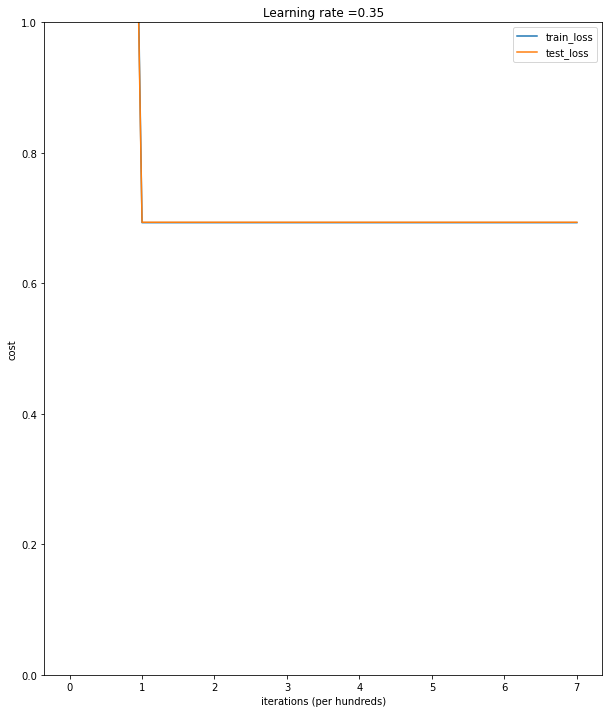

In [15]:
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.35, 
                      num_iterations = 7001, 
                      lambd = 30, #->high regularization, hyperparameter, subject to tune
                      init_method= "xavier",
                      print_cost = True
                      )

## Dropout
Dropout is a regularization technique that we use to prevent overfitting in our neural network models. We ignore randomly selected neurons from the network while training. This prevents the activations of those neurons continuing down the line, and the weight updates are not applied to them during back propagation. The weights of neurons are tuned to identify specific features; neurons that neighbor them become dependent on this, which can lead to overfitting because these neurons can get specialized to the training data. When neurons are randomly dropped, the neighboring neurons step in and learn the representation, leading to multiple different representations being learned by the network. This make the network generalize better and prevents the model from overfitting. One import thing to keep in mind is that dropout layers should not be used when you are performing predictions or testing your model. This would make the model lose valuable information and would lead to a loss in performance.

 We generally use a dropout probability between 0.2 and 0.5. This probability refers to the probability by which a neuron will be dropped from training. 
 
 <img src="imgs/do.png" style="width:600px;height:400px;">

In [16]:
from utils import backward_propagation_with_dropout

In [17]:
def forward_propagation_with_dropout(X, parameters, keep_prob = 0.5):
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    z1 = np.dot(W1, X) + b1
    a1 = relu(z1)

    # Steps 1-4 below correspond to the Steps 1-4 described above. 
    D1 = np.random.rand(a1.shape[0], a1.shape[1])     # Step 1: initialize matrix D1 = np.random.rand(..., ...)
    D1 = (D1 < keep_prob)                             # Step 2: convert entries of D1 to 0 or 1 (using keep_prob as the threshold)
    a1 = a1 * D1                                      # Step 3: shut down some neurons of A1
    a1 = a1/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down

    z2 = np.dot(W2, a1) + b2
    a2 = relu(z2)

    D2 = np.random.rand(a2.shape[0], a2.shape[1])     # Step 1: initialize matrix D2 = np.random.rand(..., ...)
    D2 = (D2 < keep_prob)                             # Step 2: convert entries of D2 to 0 or 1 (using keep_prob as the threshold)
    a2 = a2 * D2                                      # Step 3: shut down some neurons of A2
    a2 = a2/keep_prob                                 # Step 4: scale the value of neurons that haven't been shut down

    z3 = np.dot(W3, a2) + b3
    a3 = sigmoid(z3)
    
    cache = (z1, D1, a1, W1, b1, z2, D2, a2, W2, b2, z3, a3, W3, b3)
    
    return a3, cache


In the first part, we used the regularization and added a new confirmation to the cost function. As a result, the gradient of the cost function to the weights changed. In Dropout, we change the feedforward network by switching off many units, and therefore the gradient of the cost function to the weights will change because the number of weights we want to update in each iteration will be smaller.

**Note:** When we evaluate the network, we don't use dropout.

In [27]:
# GRADED FUNCTION: optimize
def optimize(X, Y, X_test, Y_test, learning_rate = 0.01, num_iterations = 15000, print_cost = True,  keep_prob = 1, init_method ="xavier"):
    
    grads      = {}
    costs      = {'train': [], 'test':[]} # to keep track of the loss
    accuracies = {'train': [], 'test':[]} # to keep track of the accuracy
    # to keep track of the accuracy
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 60,35, 1]    

    parameters = initialize_parameters(layers_dims,init_method)

    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.        
        if keep_prob == 1:
            a3, cache = forward_propagation(X, parameters)
            
        elif keep_prob < 1:    
            a3, cache = forward_propagation_with_dropout(X, parameters, keep_prob)
        
        # Compute Cost
        cost = compute_cost(a3, Y)
        
        # Back Propagation
        if keep_prob == 1:
            grads = backward_propagation(X, Y, cache)
        elif keep_prob < 1:
            grads = backward_propagation_with_dropout(X, Y, cache, keep_prob)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 1000 == 0:
            print("Cost Train after iteration {}: {:.3f}".format(i, cost))
            # Compute the predictions 
            predictions_train = predict_dec(X,parameters)
            predictions_test  = predict_dec(X_test,parameters)
            # Compute the accuracy 
            accuracy_train = np.mean(predictions_train[0,:] == Y[0,:])
            accuracy_test  = np.mean(predictions_test[0,:]  == Y_test[0,:])
            # Cost function
            a3_a, _ = forward_propagation(X_test, parameters)
            cost_test = compute_cost(a3_a, Y_test)
            print("Cost Test after iteration {}: {:.3f}".format(i, cost_test))
            print("================")
            costs['train'].append(cost)
            costs['test'].append(cost_test)
            accuracies['train'].append(accuracy_train)            
            accuracies['test'].append(accuracy_test)

            
    # plot the loss, accuracy
    fig1, ax1 = plt.subplots(figsize=(10,12), nrows=1, ncols=1)
    ax1.plot(costs['train'],label='train_loss')
    ax1.plot(costs['test'] ,label='test_loss')
    ax1.set_ylabel('cost')
    ax1.set_xlabel('iterations (per hundreds)')
    ax1.set_title("Learning rate =" + str(learning_rate))
    ax1.legend(loc='best')
    ax1.set_ylim([0,1])
    plt.show()
    return parameters

Cost Train after iteration 0: 0.688
Cost Test after iteration 0: 0.655
Cost Train after iteration 1000: 0.196
Cost Test after iteration 1000: 0.271
Cost Train after iteration 2000: 0.172
Cost Test after iteration 2000: 0.311
Cost Train after iteration 3000: 0.167
Cost Test after iteration 3000: 0.389
Cost Train after iteration 4000: 0.130
Cost Test after iteration 4000: 0.481
Cost Train after iteration 5000: 0.109
Cost Test after iteration 5000: 0.605
Cost Train after iteration 6000: 0.108
Cost Test after iteration 6000: 0.773
Cost Train after iteration 7000: 0.106
Cost Test after iteration 7000: 0.938


C:\Users\r\.conda\envs\D4LCN\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\r\.conda\envs\D4LCN\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


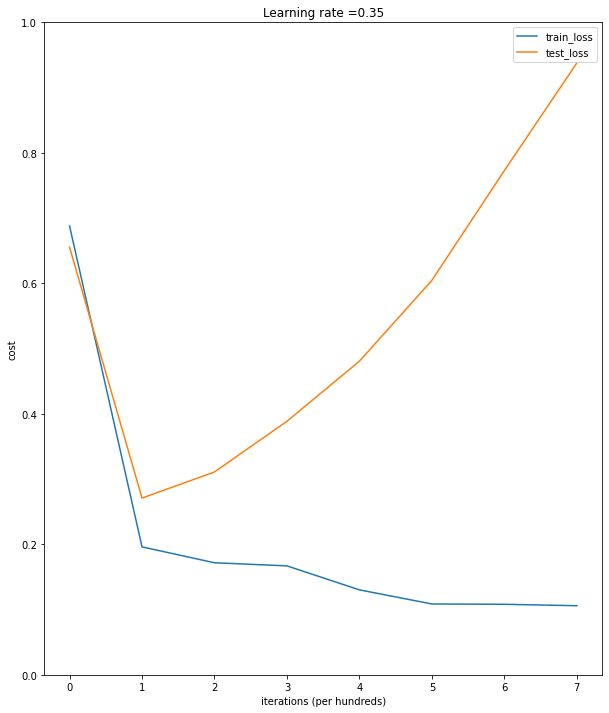

In [28]:
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.35, 
                      num_iterations = 7001, 
                      keep_prob = 1., 
                      init_method= "xavier",
                      print_cost = True
                      )

Cost Train after iteration 0: 0.705
Cost Test after iteration 0: 0.670


C:\Users\r\.conda\envs\D4LCN\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\r\.conda\envs\D4LCN\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in multiply
  This is separate from the ipykernel package so we can avoid doing imports until


Cost Train after iteration 1000: 0.222
Cost Test after iteration 1000: 0.283
Cost Train after iteration 2000: 0.238
Cost Test after iteration 2000: 0.318
Cost Train after iteration 3000: 0.171
Cost Test after iteration 3000: 0.373
Cost Train after iteration 4000: 0.170
Cost Test after iteration 4000: 0.417
Cost Train after iteration 5000: 0.173
Cost Test after iteration 5000: 0.473
Cost Train after iteration 6000: 0.183
Cost Test after iteration 6000: 0.521
Cost Train after iteration 7000: 0.187
Cost Test after iteration 7000: 0.589


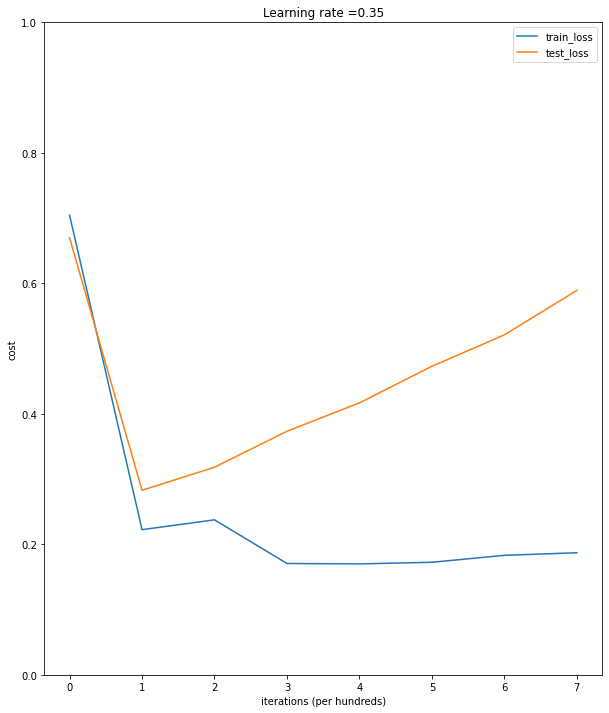

In [29]:
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.35, 
                      num_iterations = 7001, 
                      keep_prob = 0.4, 
                      init_method= "xavier",
                      print_cost = True
                      )

## Early stopping
During training, we know that our neural networks have a tendency to overfit to the training data over many iterations, and then they are unable to generalize what they have learned to perform well on the test set. One way of overcoming this problem is to stop the training earlier.

In [30]:
# GRADED FUNCTION: optimize
def optimize(X, Y, X_test, Y_test, learning_rate = 0.01, num_iterations = 15000, print_cost = True, init_method ="xavier"):
    
    grads      = {}
    costs      = {'train': [], 'test':[]} # to keep track of the loss
    accuracies = {'train': [], 'test':[]} # to keep track of the accuracy
    # to keep track of the accuracy
    m = X.shape[1] # number of examples
    layers_dims = [X.shape[0], 60,35, 1]    

    parameters = initialize_parameters(layers_dims,init_method)
    
    # parameters for early stopping
    old_cost_test   = 10.
    counter    = 0 
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.        
        a3, cache = forward_propagation(X, parameters)
            
        # Compute Cost
        cost = compute_cost(a3, Y)
        
        # Back Propagation
        grads = backward_propagation(X, Y, cache)

        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 1000 iterations
        if print_cost and i % 300 == 0:
            print("Cost Train after iteration {}: {:.3f}".format(i, cost))
            # Compute the predictions 
            predictions_train = predict_dec(X,parameters)
            predictions_test  = predict_dec(X_test,parameters)
            # Compute the accuracy 
            accuracy_train = np.mean(predictions_train[0,:] == Y[0,:])
            accuracy_test  = np.mean(predictions_test[0,:]  == Y_test[0,:])
            #print("The train accuracy  after iteration {}: {:.3f}".format(i, accuracy_train))
            #print("The test accuracy after iteration {}: {:.3f}".format(i, accuracy_test))
            # Cost function
            a3_a, _ = forward_propagation(X_test, parameters)
            cost_test = compute_cost(a3_a, Y_test)
            print("Cost Test after iteration {}: {:.3f}".format(i, cost_test))
            print("================")

            # Early stopping
            if (cost_test - old_cost_test) > 0.0:
                print("Early Stopping, the cost rose from {:.3f} to {:.3f}".format(old_cost_test, cost_test))
                if counter == 3:
                    print("Stop the training, there is no reduction in the loss function")
                    break
                else:
                    counter += 1
            else:
                # Reset the counter 
                counter = 0
            old_cost_test = cost_test


            costs['train'].append((cost))
            costs['test'].append((cost_test))
            accuracies['train'].append(accuracy_train)            
            accuracies['test'].append(accuracy_test)

            
    # plot the loss, accuracy
    fig1, ax1 = plt.subplots(figsize=(10,12), nrows=1, ncols=1)
    ax1.plot(costs['train'],label='train_loss')
    ax1.plot(costs['test'] ,label='test_loss')
    ax1.set_ylabel('cost')
    ax1.set_xlabel('iterations (per hundreds)')
    ax1.set_title("Learning rate =" + str(learning_rate))
    ax1.legend(loc='best')
    ax1.set_ylim([0,1])
    plt.show()
    return parameters

Cost Train after iteration 0: 0.697
Cost Test after iteration 0: 0.670
Cost Train after iteration 300: 0.216
Cost Test after iteration 300: 0.253
Cost Train after iteration 600: 0.208
Cost Test after iteration 600: 0.257
Early Stopping, the cost rose from 0.253 to 0.257
Cost Train after iteration 900: 0.200
Cost Test after iteration 900: 0.262
Early Stopping, the cost rose from 0.257 to 0.262
Cost Train after iteration 1200: 0.192
Cost Test after iteration 1200: 0.266
Early Stopping, the cost rose from 0.262 to 0.266
Cost Train after iteration 1500: 0.187
Cost Test after iteration 1500: 0.269
Early Stopping, the cost rose from 0.266 to 0.269
Stop the training, there is no reduction in the loss function


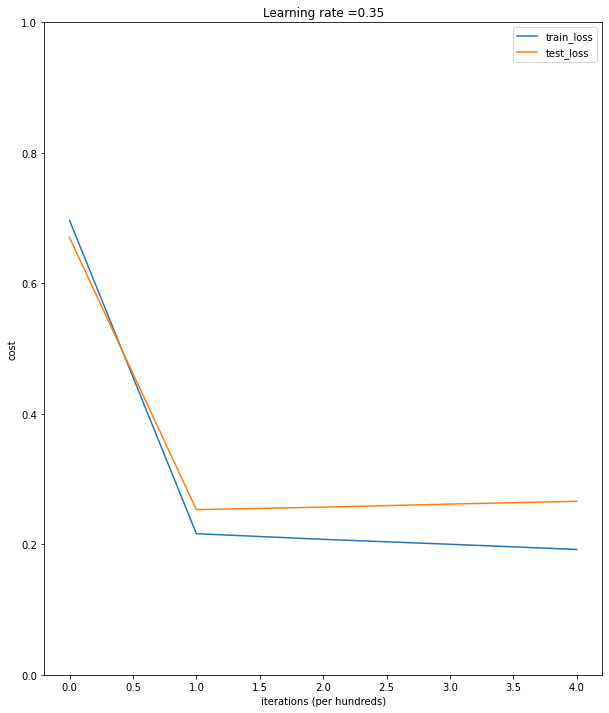

In [31]:
parameters = optimize(train_X, train_Y, test_X, test_Y , 
                      learning_rate = 0.35, 
                      num_iterations = 7001, 
                      init_method= "xavier",
                      print_cost = True
                      )

## References
1. Data Science with Python By Rohan Chopra, Aaron England, Mohamed Noordeen Alaudeen (packtpub)
4. Deep Learning Specialization on Coursera
5. https://github.com/Kulbear/deep-learning-coursera